In [50]:
import sys, site, platform
print("Python exe:", sys.executable)
print("Python ver:", platform.python_version())
!{sys.executable} -m pip --version
!{sys.executable} -m pip show py-feat hmmlearn tqdm graphviz celluloid


Python exe: /home/yuriy/Projects/avatar_detectionsystem-2_common/114/apiapp/server/.venv/bin/python
Python ver: 3.11.13
pip 24.3.1 from /home/yuriy/Projects/avatar_detectionsystem-2_common/114/apiapp/server/.venv/lib/python3.11/site-packages/pip (python 3.11)
Name: py-feat
Version: 0.6.2
Summary: Facial Expression Analysis Toolbox
Home-page: https://github.com/cosanlab/py-feat
Author: Jin Hyun Cheong, Tiankang Xie, Sophie Byrne, Eshin Jolly, Luke Chang
Author-email: jcheong0428@gmail.com, eshin.jolly@gmail.com, luke.j.chang@dartmouth.edu
License: MIT license
Location: /home/yuriy/Projects/avatar_detectionsystem-2_common/114/apiapp/server/.venv/lib/python3.11/site-packages
Requires: av, celluloid, easing-functions, h5py, joblib, kornia, matplotlib, nltools, numexpr, numpy, pandas, Pillow, pywavelets, scikit-image, scikit-learn, seaborn, torchvision, tqdm, xgboost
Required-by: 
---
Name: hmmlearn
Version: 0.3.3
Summary: Hidden Markov Models in Python with scikit-learn like API
Home-page:

In [51]:
%pip install -U py-feat hmmlearn tqdm graphviz celluloid
# quick check and SciPy compatibility shim for py-feat expecting scipy.integrate.simps
import scipy
try:
    from scipy import integrate as _integrate
    if not hasattr(_integrate, "simps"):
        from scipy.integrate import simpson as _simpson
        setattr(_integrate, "simps", _simpson)
except Exception as _e:
    print("Warning: could not alias scipy.integrate.simpson to simps:", _e)
# Compatibility shim for environments where lib2to3 is unavailable (e.g., Py3.12+)
try:
    import sys as _sys, types as _types
    if 'lib2to3.pytree' not in _sys.modules:
        _lib2to3 = _types.ModuleType('lib2to3')
        _pytree = _types.ModuleType('lib2to3.pytree')
        def convert(node):  # minimal stub used by py-feat's ResMaskNet wrapper
            return node
        _pytree.convert = convert
        _lib2to3.pytree = _pytree
        _sys.modules['lib2to3'] = _lib2to3
        _sys.modules['lib2to3.pytree'] = _pytree
except Exception as _e:
    print("Warning: could not create lib2to3 compatibility shim:", _e)
import feat, hmmlearn, graphviz, celluloid
# Compatibility: ensure feat.Fex exists for py-feat versions that don't export it at top-level
try:
    if not hasattr(feat, "Fex"):
        from feat.data import Fex as _Fex
        setattr(feat, "Fex", _Fex)
except Exception as _e:
    print("Warning: could not alias feat.data.Fex to feat.Fex:", _e)
print("feat:", getattr(feat, "__version__", "n/a"))



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
feat: 0.6.2


# System Graphviz requirement
# If the DOT rendering below fails, install Graphviz:
# - Linux (Debian/Ubuntu): sudo apt-get install -y graphviz
# - macOS: brew install graphviz
# - Windows: Install Graphviz and add its bin directory to PATH

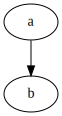

In [52]:
import graphviz as _gvz_test
from IPython.display import display
import shutil as _shutil
_dot = _gvz_test.Digraph()
_dot.node('a'); _dot.node('b'); _dot.edge('a','b')
if _shutil.which('dot'):
    display(_dot)
else:
    print("Graphviz 'dot' executable not found on PATH. Install system Graphviz to render diagrams.")
    print("Linux (Debian/Ubuntu): sudo apt-get install -y graphviz")
    print("macOS: brew install graphviz")
    print("Windows: Install Graphviz and add its bin directory to PATH")
    print("DOT source (you can paste this into an online Graphviz viewer):")
    print(_dot.source)


# Использование HMM на реальных данных

Данный блокнот можно немного преувеличив минимальным прототипом аватара. Он демонстрирует выделение из видео признаков типа [F.A.C.S. Action Units]((https://en.wikipedia.org/wiki/Facial_Action_Coding_System#Method), обучение по ним скрытой марковской цепи (Hidden Markov Model, HMM) и анимацию предсказания.

При анализе данных используется цепочка,
```
Image -> Land Marks -> FACS Action Units -> HMM
```
а в обратном ходе, при демонстрации аватаром лицевой анимации практически идентичная обратная
```
HMM -> FACS Action Units -> Animator -> Image
```

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy
import itertools
from feat.data import Fex
from feat.utils.io import read_feat

from hmmlearn import hmm
from tqdm.std import tqdm
import tqdm.contrib.itertools as tqdm_itertools

import graphviz

## Выделение признаков

Данные были получены при помощи библиотеки `py-feat`, которая умеет выделять из видео не только эмоции и опорные точки лица, но и Action Units системы FACS, что позволяет достаточно просто обратить преобразование и анимировать изображение.

In [54]:
from feat.detector import Detector
from feat.utils.io import get_test_data_path
import os

enabled     = False         # False means do nothing
video_path  = '/fix/me'
csv_path    = '/fix/me/too'
fps         = 25
skip_frames = fps           # start detection every second
face_detection_threshold = 0.95

if enabled:
    detector = Detector()
    
    video_prediction = detector.detect_video(
        video_path,
        skip_frames=skip_frames,
        face_detection_threshold=face_detection_threshold
    )
    
    print(f"Saving to csv {csv_path}")
    video_prediction.to_csv(csv_path)


Класс `feat.data.Fex`, экземпляром которого является video_prediction является оберткой над pandas DataFrame. Данные из него можно сохранять стандартными методами `pandas`, прочитать данные из csv обратно в `feat.data.Fex` можно при помощи `feat.utils.io.read_feat`.

In [55]:
data_path = 'data/2019-11-05_17-34-46-Cam0.csv'

# Robustly read FEX CSV: try py-feat's read_feat; if it fails due to missing feat.Fex top-level,
# fall back to constructing Fex directly from feat.data using constants from feat.utils.io.
try:
    data = read_feat(data_path)
except AttributeError as e:
    import pandas as pd
    import feat as _feat
    # Ensure feat.Fex exists for compatibility with py-feat 0.6.x
    try:
        Fex = getattr(_feat, "Fex")
    except AttributeError:
        from feat.data import Fex as _Fex
        setattr(_feat, "Fex", _Fex)
        Fex = _Fex
    from feat.utils.io import (
        FEAT_EMOTION_COLUMNS,
        FEAT_FACEBOX_COLUMNS,
        FEAT_TIME_COLUMNS,
        openface_2d_landmark_columns,
    )
    d = pd.read_csv(data_path)
    au_columns = [col for col in d.columns if "AU" in col]
    data = Fex(
        d,
        filename=data_path,
        au_columns=au_columns,
        emotion_columns=FEAT_EMOTION_COLUMNS,
        landmark_columns=openface_2d_landmark_columns,
        facebox_columns=FEAT_FACEBOX_COLUMNS,
        time_columns=FEAT_TIME_COLUMNS,
        facepose_columns=["Pitch", "Roll", "Yaw"],
        detector="Feat",
    )

display(data)

,frame,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,...,Identity_506,Identity_507,Identity_508,Identity_509,Identity_510,Identity_511,Identity_512,input,frame.1,approx_time
0,0,552.228447,234.907543,294.547830,430.743182,0.998109,533.474727,536.409884,543.464834,554.705615,...,0.084257,-0.036940,0.042500,-0.016232,0.038723,0.074294,-0.045343,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,0,00:00
1,25,547.547666,232.236796,297.105293,436.905043,0.998266,532.898309,535.535572,542.204305,552.920773,...,0.087330,-0.027688,0.037983,-0.018535,0.045254,0.078598,-0.049255,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,25,00:01
2,50,547.085259,230.146992,298.485543,439.968903,0.998377,532.875874,535.769899,542.634632,553.310688,...,0.091887,-0.026540,0.039663,-0.020008,0.047929,0.074559,-0.049308,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,50,00:02
3,75,543.871207,231.905862,297.703602,436.730056,0.998465,530.851597,533.680875,540.380884,551.095091,...,0.089667,-0.027624,0.039284,-0.017401,0.050178,0.076037,-0.052258,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,75,00:03
4,100,545.973171,233.737574,295.826781,435.552277,0.998256,529.293922,532.328330,539.165094,549.865282,...,0.089284,-0.026742,0.037668,-0.018124,0.045886,0.075792,-0.044758,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,100,00:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,10450,606.454607,250.198161,304.745026,414.537910,0.997687,596.028282,591.680086,592.152849,598.197547,...,0.090237,-0.032405,0.044863,-0.023863,0.047819,0.082969,-0.034510,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,10450,06:58
419,10475,609.587960,248.944963,291.213764,417.413147,0.997802,595.238209,591.018746,591.762303,598.121249,...,0.096973,-0.031550,0.042423,-0.028677,0.039181,0.075109,-0.040604,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,10475,06:59
420,10500,608.597204,248.781753,292.189447,417.364380,0.997881,595.934896,591.574591,592.130424,598.350501,...,0.095804,-0.030461,0.037923,-0.019580,0.038524,0.081636,-0.029180,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,10500,07:00
421,10525,604.751495,245.466940,304.926145,422.061784,0.997693,594.397516,590.673944,591.774885,597.977747,...,0.093611,-0.040855,0.052874,-0.019804,0.035093,0.067575,-0.028447,/storage/avatar2/2019-11-05_17-34-46/Cam0.mp4,10525,07:01


In [ ]:
axes = data.emotions.plot()
observation = data.aus
labels = list(data.aus.columns)

## Обучение HMM на FACS Action Units

In [ ]:
train_validate_fraction = .75   # train/validate
min_state_n             = 2     # must be positive
max_state_n             = 20    # must be grater than min_state_n
attempts_to_fit_n      = 20    # number of attempts to fit a model
                                # initial random state will different for each attempt
show_progress_bar       = True  # show progress bar of overall training process
print_log               = False # print a message per a trained model
verbose                 = False # print verbose log of training for every model
random_state            = 0     # random state seed, must be unsigned 32 bit integer
n_samples_after         = 200   # number of states to generate after validating sequence
raw_data_multiplier     = 100   # number to multiply data before conservation to integer 

X = np.array((raw_data_multiplier * (observation - np.min(observation))).astype(np.int_)) # for Poisson HMM all values must be positive
# Sanity checks for PoissonHMM
assert np.issubdtype(X.dtype, np.integer), "X must be integer dtype"
assert X.min() >= 0, "X must be non-negative"

train_validate_border = int(X.shape[0] * train_validate_fraction)

X_train    = X[:train_validate_border]
X_validate = X[train_validate_border:]

scores = list()
models = list()

product = tqdm_itertools.product if show_progress_bar else itertools.product

for idx, n_components in product(range(attempts_to_fit_n),
                                     range(min_state_n, max_state_n)):
        model = hmm.PoissonHMM(n_components = n_components,
                               random_state=idx,
                               verbose=verbose)
        try:
            model.fit(X_train)
        except ValueError as e:
            raise ValueError("PoissonHMM fitting failed. Ensure observations are non-negative integers and sufficient in length.") from e
        models.append(model)
        scores.append(model.score(X_validate))
        if print_log:
            print(f'Converged: {model.monitor_.converged}'
                  f'\tScore: {scores[-1]}')

# get the best model
model = models[np.argmax(scores)]
print(f'The best model had a score of {max(scores)} and '
      f'{model.n_components} components')

# use the Viterbi algorithm to predict the most likely sequence of states
# of the given the model for the train sequence
states_train       = model.predict(X_train)
# generate states with the model without any information from real data
_, states_validate = model.sample(n_samples = len(X_validate) + n_samples_after,
                              random_state = random_state)
states = np.concatenate([states_train, states_validate])

Демонстрации реальных и сгенерированных данных на одном графике

In [ ]:
# plot model states over time
X_label         = list(map(lambda label: f"real {label}", labels))
fitted_label     = list(map(lambda label: f"predicted {label}", labels))
first_au_num    = 16
last_au_num     = 100 # feel free to set value greater then the maximum AU number
aus_range       = range(first_au_num, min(X.shape[1], model.lambdas_[states].shape[1], last_au_num))

fig, ax = plt.subplots()
for i in aus_range:
    line, = ax.plot(X[:,i],
            linestyle="--",
            label = X_label[i])
    ax.plot(model.lambdas_[states][:,i],
            color = line.get_color(),
            label = fitted_label[i])
ax.axvline(x = train_validate_border,
           linestyle = 'dotted',
           color = 'gray',
           label = 'train/validate border')
ax.axvline(x = X.shape[0],
           linestyle = 'dashed',
           color = 'gray',
           label = 'end of real data')
ax.legend(loc = (1.05,0))
ax.set_title('Predicted data and real data comparation')
ax.set_xlabel('Frame number')
plt.show()

## Визуализация внутреннего устройства HMM
Внутренние состояния HMM организованы в граф, на ребрах которого отмечены вероятности переходов. Изобразим его матрицу смежности и сам граф.

In [ ]:
fig, ax = plt.subplots()
# ax.imshow(model.transmat_, aspect='auto', cmap='spring')
plot = ax.pcolormesh(model.transmat_,
               edgecolors='white',
               linewidth=1)
fig.colorbar(plot)
ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')
plt.show()

In [ ]:
min_prob_to_plot_an_edge = 0.01
float_format = "{0:0.2f}"

matrix = np.array(model.transmat_)

assert(len(matrix.shape) == 2)
assert(matrix.shape[0] == matrix.shape[1])

dot = graphviz.Digraph('HMM graph', comment='HMM graph')

for i in range(matrix.shape[0]):
    dot.node(str(i), str(i))

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        prob = matrix[i, j]
        if prob > min_prob_to_plot_an_edge:
            formated_prob = float_format.format(prob)
            dot.edge(str(i), str(j), label = float_format.format(prob))
from IPython.display import display
import shutil as _shutil
if _shutil.which('dot'):
    display(dot)
else:
    print("Graphviz 'dot' executable not found on PATH. Install system Graphviz to render diagrams.")
    print("Linux (Debian/Ubuntu): sudo apt-get install -y graphviz")
    print("macOS: brew install graphviz")
    print("Windows: Install Graphviz and add its bin directory to PATH")
    print("DOT source (you can paste this into an online Graphviz viewer):")
    print(dot.source)

# Анимация аватара
Ключевое в данном блокноте именно возможность обратного хода, то есть генерации поведения после обучения. HMM генерирует временной ряд FACS Action Units, по которым анимируется аватар. Для простоты интеграции с jupiter используется примитивная картинка из библиотеки `py-feat`, однако существуют готовые решения, которые позволяют по Action Units 3d модели, о них ниже.

## Анимация по FACS Action Units
### FACS Avatar
Докер контейнер, позволяющий анимировать при помощи FACS action units модель в Blender, Unity или MakeHuman. [GitHub](https://github.com/NumesSanguis/FACSvatar), лицензия LGPL. Был собран на базе нескольких других готовых проектов одним человеком, сейчас не поддерживается.

In [ ]:
from IPython.display import Image
Image(filename='../why_FACS_control_trans.png')

### OpenFace FACS Unity Facial Animator
Докер контейнер, который позволяет при помощи Action Units анимировать аватар на Unity.
[Github](https://github.com/alexismorin/OpenFace-FACS-Unity-Facial-Animator), лицензия LGPL. Входит в состав FACS Avatar.

### OpenFacs
Код на C++, которые локально рендерит аватар и позволят динамически менять его выражение лица посылая новые Action Units по UDP. Проект единожды написанный для статьи и с тех пор заброшен, но запускается и работает. [GitHub](https://github.com/phuselab/openFACS), лицензия MIT.

## Анимация в этом блокноте
Признаки выделялись только в каждом 25-ом кадре, то есть каждую секунду. Из-за этого движение глаз и рта хаотичны как на модели "оригинале", так и на аватаре.

In [ ]:
from celluloid import Camera
from IPython.display import HTML
from feat.plotting import plot_face

def animate_au(fig, ax, aus, *args, **kwargs,):
    camera = Camera(fig)
    
    for au in tqdm(aus):
        # ax.clear()
        ax = plot_face(
            model=None,
            ax=ax,
            au=au,
            *args,
            **kwargs,
        )
        camera.snap()
    ani = camera.animate()
    return ani

In [ ]:
animation_fps = 10
animation_dpi = 300
animation_filename = "input.gif"

fig, ax = plt.subplots(figsize=(4,5))
ani = animate_au(fig, ax, X / float(raw_data_multiplier))
print("Person's face")
HTML(ani.to_jshtml())

In [ ]:
fig, ax = plt.subplots(figsize=(4,5))
ani = animate_au(fig, ax, model.lambdas_[states] / float(raw_data_multiplier))
print("Avatar's face")
HTML(ani.to_jshtml())

# Эмоции как исходные данные для HMM
В примере выше эмоции вообще никак не учитываются при моделировании. HMM принимает на вход только наблюдаемые Action Units, эмоций для нее не существует.

Может оказаться, что лучше все таки концепцию эмоций использовать. Тогда пути данных в прямом и обратном направлении будут такими:
```
Image -> Land Marks -> FACS Action Units -> Emotions -> HMM
```
```
HMM -> Emotions -> FACS Action Units -> Animator -> Image
```
## Распознавание эмоций
Эмоции по FACS Action Units можно распознавать при помощи ML моделей, так и делает библиотека `py-feat`. Проблема в том, такое преобразование получается необратимым. По Action Units эмоции восстановить можно, а как из модели достать обратное преобразование не ясно.

Будем использовать другой, более простой и не связанный с ML
подход. Назовем эмоцией подпространство в пространстве action
units. Выражение лица описывается вектором в Action Units пространстве. Степень выражения соответствия выражения лица эмоции равна углу между подпространством эмоции и вектором выражения лица.

Некоторые эмоции могут иметь несколько способов выражения. Так удивляясь человек может приоткрыть рот, а может и нет. Правильнее сказать, что что эмоция -- класс эквивалентности подпространств в пространстве Action Units. Но будем для простоты считать, удивление с открытым ртом и закрытым -- разные эмоции.

TODO: Refactoring, Выделить связанные с эмоциями функции и структуры данных в класс.

In [ ]:
def auName2auNum(name : str):
    return int(name[-2:])
def auNum2auName(number : int):
    return f"AU{int(number):02d}"
def test_auName2auNum_auNum2auName():
    for name in list(data.aus.columns):
        number = auName2auNum(name)
        name_test = auNum2auName(number)
        if (name_test != name):
            print(f"Failed {name} -> {number} -> {name_test}")
            assert(False)
test_auName2auNum_auNum2auName()

Данные об эмоциях-подпространствах возьмем из книги Paul Ekman, Wallace V. Friesen, Joseph C. Hager, "Facial Action Coding System Investigator’s Guide". В книге вводится интуитивно понятный DSL для их описания в виде формальных сумм. Звездочка (*) около номера Action Unit означает, что этот Action Unit может быть выражен в любой степени.

In [ ]:
# table from Facial Action Coding System Investigator’s Guide, by Paul Ekman, Wallace V. Friesen, Joseph C. Hager
emotions = {
    'anger' : {
        '4+5*+7+10*+22+23+25',
        '4+5*+7+23+25',
        '4+5*+7+10*+22+23+26',
        '4+5*+7+23+26',
        '4+5*+7+17+23',
        '4+5*+7+17+24',
        '4+5*+7+23',
        '4+5*+7+24',
    },
    'disgust' : {
        '9',
        '9+16+15',
        '9+16+26',
        '9+17',
        '10*',
        '10*+16+26',
        '10*+16+25',
        '10+17',
    },
    'fear' : {
        '1+2+4+5*+20*+25',
        '1+2+4+5*+25',
        '1+2+4+5*+20*+26',
        '1+2+4+5*+26',
        '1+2+4+5*+20*+27',
        '1+2+4+5*+27',
    }, 
    'happiness' : {
        '6+12*',
        '12',
    },
    'sadness' : {
        '1+4+11+15',
        '1+4+15*',
        '6+15*',
    },
    'surprise' : {
        '1+2+5+26',
        '1+2+5+27',
    },
    #'neutral' : {}
}

Подпространство эмоции будем описывать при помощи ортогонально проецирующей матрицы. `parseAdditiveCombination` конвертируют строку формальной суммы в матрицу-проектор на подпространство.

In [ ]:
def parseAdditiveCombination(combination: str, aus_space: list):
    au_strs = combination.split('+')
    N = len(aus_space)
    if N == 0:
        return None
    # Build index for O(1) lookup
    idx_by_au = {name: i for i, name in enumerate(aus_space)}

    vector_sum = np.zeros(N)
    direct_sum = []  # rows = basis vectors

    for au_str in au_strs:
        try:
            add_to_direct_sum = (au_str[-1] == '*')
            if add_to_direct_sum:
                au_str = au_str[:-1]  # remove asterisk
            au_name = auNum2auName(int(au_str))
            idx = idx_by_au.get(au_name)
            if idx is None:
                # AU is not present in the current space; skip it
                continue
        except Exception as e:
            raise ValueError(f"Invalid term \"{au_str}\" in additive combination \"{combination}\"") from e

        vector = np.zeros(N)
        vector[idx] = 1

        if add_to_direct_sum:
            direct_sum.append(vector)
        else:
            vector_sum += vector

    norm = np.linalg.norm(vector_sum)
    if norm > 0:
        vector_sum = vector_sum / norm
        direct_sum.append(vector_sum)

    if len(direct_sum) == 0:
        return None
    return np.stack(direct_sum, axis=0)

def test_parseAdditiveCombination():
    N = 3
    au_labels = list(map(auNum2auName, np.arange(N) + 1))
    ones = np.ones(N)
    assert np.allclose(parseAdditiveCombination('1*+2*+3*', au_labels), np.eye(N))
    expected = (ones / np.linalg.norm(ones))[None, :]
    assert np.allclose(parseAdditiveCombination('1+2+3', au_labels), expected)
    assert parseAdditiveCombination('42', au_labels) is None

test_parseAdditiveCombination()

Как уже было сказано выше, степень варажения соответствия выражения лица эмоции равнауглу между подпространством эмоции и ветором выражения лица.

In [ ]:
def subspace_angles_rows(A_rows: np.ndarray, B_rows: np.ndarray):
    """Compute principal angles between two subspaces with bases given in rows."""
    A = np.atleast_2d(A_rows)
    B = np.atleast_2d(B_rows)
    return scipy.linalg.subspace_angles(A.T, B.T)


def emotion_value(emotion_projector: np.ndarray, face_expression: np.ndarray):
    """Angles between an emotion subspace (rows as basis) and a face-expression vector."""
    # If a vector is provided, make it a single row; if already a matrix, use as-is
    if isinstance(face_expression, np.ndarray) and face_expression.ndim == 1:
        v_rows = face_expression.reshape(1, -1)
    else:
        v_rows = np.atleast_2d(face_expression)
    return subspace_angles_rows(emotion_projector, v_rows)

In [ ]:
emotion_spaces = {}
for emotion_name, sum_strs in emotions.items():
    subspaces = []
    for sum_str in sum_strs:
        subspace = parseAdditiveCombination(sum_str, list(data.aus.columns))
        if subspace is None:
            continue
        if len(subspaces) == 0:
            subspaces.append(subspace)
            continue
        # check if subspace has already been added (near-zero principal angle)
        angles_list = [subspace_angles_rows(subspace, existing) for existing in subspaces]
        near_zero = any((angles_arr < 1e-8).any() for angles_arr in angles_list)
        if not near_zero:
            subspaces.append(subspace)
    emotion_spaces[emotion_name] = subspaces

# display(emotion_spaces)

In [ ]:
import sys, numpy, pandas, scipy, matplotlib, sklearn, hmmlearn
import feat
print("Python:", sys.version)
print("numpy:", numpy.__version__)
print("pandas:", pandas.__version__)
print("scipy:", scipy.__version__)
print("matplotlib:", matplotlib.__version__)
print("scikit-learn:", sklearn.__version__)
print("py-feat:", getattr(feat, "__version__", "n/a"))
print("hmmlearn:", hmmlearn.__version__)